In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

class FofecastDataset(Dataset):
    def __init__(
            self,
            df: pd.DataFrame,
            seq_len: int,
            target: str,
            save_collumns: bool = False,
            forecast_horizon: int = 1
        ):
        self.seq_len = seq_len
        self.forecast_horizon = forecast_horizon
        self.target = target

        df = df.copy()
        source_cols = df.columns
        df_cols = [target] + [col for col in df.columns if col != target and save_collumns]
        # Преобразование даты в datetime если еще не преобразована
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        self.dates = df.index.copy()
        self.min_date = df.index.min()
        self.freq = self._infer_frequency(df.index)

        df = self._add_time_features(df)

        self.df = df

        self.df_cols = df_cols
        self.feature_cols = [col for col in df.columns if col not in source_cols]
        self.values = df[df_cols + self.feature_cols].values


    def _infer_frequency(self, date_index):
        """Определяет частоту временного ряда"""

        return date_index[1] - date_index[0]

    def _add_time_features(self, df):
        """Добавляет временные признаки"""

        df['date'] = df.index

        df['dow_sin'] = np.sin(2 * np.pi * df['date'].dt.weekday / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['date'].dt.weekday / 7)
        df['month_sin'] = np.sin(2 * np.pi * (df['date'].dt.month-1) / 12)
        df['month_cos'] = np.cos(2 * np.pi * (df['date'].dt.month-1) / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / 31)
        df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / 31)
        df['is_holiday'] = (df['date'].dt.weekday > 4).astype(int)

        if not self.freq.days:
            df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / 24)
       
        df = df.drop('date', axis=1)

        return df

    def get_future_time_features(self, start_date, horizon):
        """
        Генерирует временные признаки для будущих дат
        """
        future_dates = pd.date_range(start=start_date, periods=horizon+1, freq=self.freq)[1:]
        future_df = pd.DataFrame(index=future_dates)
        future_df['date'] = future_df.index

        # Добавляем временные признаки
        future_df = self._add_time_features(future_df)

        # Получаем только временные признаки (без целевой переменной)
        time_features = future_df[self.feature_cols].values

        return torch.tensor(time_features, dtype=torch.float32)

    def set_forecast_horizon(
        self,
        horizon
    ):
        self.forecast_horizon = horizon

    def __len__(self):
        return len(self.df) - self.seq_len - self.forecast_horizon + 1

    def __getitem__(self, idx):
        # Входная последовательность для энкодера
        x_encoder = self.values[idx:idx + self.seq_len]

        # Целевая последовательность фактических значений
        y_true = self.values[idx + self.seq_len:idx + self.seq_len + self.forecast_horizon, 0]

        # Получаем временные признаки для периода прогнозирования
        start_date = self.dates[idx + self.seq_len - 1]
        future_time_features = self.get_future_time_features(start_date, self.forecast_horizon)

        return {
            'encoder_input': torch.tensor(x_encoder, dtype=torch.float32),
            'decoder_targets': torch.tensor(y_true, dtype=torch.float32),
            'future_time_features': future_time_features
        }


In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


def prepare_data(
    df,
    target_col,
    seq_len,
    train_horizon=7,
    val_horizon=7,
    save_collumns = False,
    batch_size=32,
    val_ratio=0.2
):

    train_df, test_df = train_test_split(df, test_size=val_ratio, shuffle=False)
    # Создаем датасет с поддержкой временных признаков
    train_dataset = FofecastDataset(train_df, seq_len, target_col, save_collumns, train_horizon)
    val_dataset = FofecastDataset(test_df, seq_len, target_col, save_collumns, val_horizon)


    # Создаем DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    input_size = next(iter(train_loader))["encoder_input"].size(2)
    features_size = next(iter(train_loader))["future_time_features"].size(2)

    return train_loader, val_loader, input_size, features_size

In [3]:
from scipy.stats import zscore

def ts_from_csv(csv_path, resampling = "h"):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['date_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    df.set_index('date_time', inplace=True)
    df.drop(columns=['date', 'time'], inplace=True)

    df = df.resample(resampling).sum().fillna(0)
    for col in df.columns:
        df[col] = np.where(zscore(df[col]) > 3, df[col].mean(), df[col])

    return df

def load_data(
    csv_path,
    freq
):
    if isinstance(csv_path, str):
        df = ts_from_csv(csv_path, freq)
    elif isinstance(csv_path , list):
        dfs = [
            ts_from_csv(csv, freq) for csv in csv_path
        ]
        df = pd.concat(
            dfs,
            axis=1,
            join = 'inner'
        )
    for col in df.columns:
        df[col]/=df[col].max()

    return df

In [4]:
import torch.nn as nn

class BaseForecast(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, rnn ,num_layers: int = 2):
        super().__init__()
        self.lstm = rnn(input_size, hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(
            self,
            inp,
            future = [],
            src = None,
            teacher_forcing_ratio = 0.5
        ):
        # inp: [batch, seq_len, input_size]
        preds = []
        out, (hidden) = self.lstm(inp)
        out = out[:, -1, :]
        preds.append(self.fc(out))
        for i in range(len(future[-1])-1):
            if src is not None:
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                last_target = src[:,i].unsqueeze(1) if teacher_force else preds[-1]
            else:
                last_target = preds[-1]

            cur_inp = torch.cat([last_target,future[:,i,:]], dim=1).unsqueeze(1)
            out, (hidden) = self.lstm(cur_inp, (hidden))
            out = out[:, -1, :]
            preds.append(self.fc(out))

        return torch.cat(preds, dim=1)

class LSTMForecast(BaseForecast):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 2):
        super().__init__(input_size, hidden_size, nn.LSTM, num_layers)

class GRUForecast(BaseForecast):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 2):
        super().__init__(input_size, hidden_size, nn.GRU, num_layers)


In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)

def train_model(model, train_loader, val_loader, epochs=30, learning_rate=0.001, teacher_forcing_ratio=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    torch.random.manual_seed(42)
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
    best_val_loss = float('inf')


    for epoch in range(epochs):
        # Обучение
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            encoder_input = batch['encoder_input'].to(device)
            decoder_targets = batch['decoder_targets'].to(device)
            future_time_features = batch['future_time_features'].to(device)

            optimizer.zero_grad()
            output = model(encoder_input, future_time_features, decoder_targets, teacher_forcing_ratio)
            loss = criterion(output.squeeze(), decoder_targets)
            loss.backward()
          
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        scheduler.step()

        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                encoder_input = batch['encoder_input'].to(device)
                decoder_targets = batch['decoder_targets'].to(device)
                future_time_features = batch['future_time_features'].to(device)

                output = model(encoder_input, future_time_features)  
                loss = criterion(output.squeeze(), decoder_targets)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_enhanced_seq2seq_model.pth')

        # Логирование 
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    model.load_state_dict(torch.load('best_enhanced_seq2seq_model.pth'))
    preds = []
    targets = []
    with torch.no_grad():
        for batch in val_loader:
            inp = batch["encoder_input"].to(device)
            target = batch["decoder_targets"].to(device)
            future = batch['future_time_features'].to(device)
            p = model(inp,future,).squeeze(-1).cpu().numpy()
            preds.extend(p)
            targets.extend(target.cpu().numpy())


    rmse = np.sqrt(mean_squared_error(targets, preds, multioutput="raw_values"))
    mae  = mean_absolute_error(targets, preds, multioutput="raw_values")
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(targets[-1], label="Target")
    plt.plot(preds[-1], label="Predictions")

    # plt.xticks(ticks=np.arange(len(rmse)), labels=[str(i) for i in range(1, len(rmse)+1)])
    plt.title('forecast')
    plt.xlabel('Horizon')
    plt.ylabel('Value')
    plt.show()
    if False:
        plt.figure(figsize=(10, 5))
        plt.plot(rmse,)
        # plt.xticks(ticks=np.arange(len(rmse)), labels=[str(i) for i in range(1, len(rmse)+1)])
        plt.title('RMSE')
        plt.xlabel('Horizon')
        plt.ylabel('Value')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(mae,)
        # plt.xticks(ticks=np.arange(len(mae)), labels=[str(i) for i in range(1, len(mae)+1)])
        plt.title('MAE')
        plt.xlabel('Horizon')
        plt.ylabel('Value')
        plt.show()

    return  mae, rmse

## SEQ2SEQ

In [6]:
import torch
import torch.nn as nn

class Seq2SeqForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, time_feature_size,):
        super(Seq2SeqForecast, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Энкодер 
        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
         
        )

        self.dec0 = nn.Linear(hidden_size, hidden_size)

        # Декодер принимает предсказанное значение объема + временные признаки
        self.decoder = nn.GRUCell(
            input_size=1 + time_feature_size, 
            hidden_size=hidden_size,
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, src, future_time_features, targets=None, teacher_forcing_ratio=0.5):

        batch_size = src.size(0)
        horizon = future_time_features.size(1)

        states, _ = self.encoder(src)

        outputs = torch.zeros(batch_size, horizon, 1, device=src.device)

        last_value = src[:, -1, 0].unsqueeze(1)  # [batch_size, 1]
        hidden = states[:,-1,:]
        hidden = self.dec0(hidden)


        # Декодирование
        for t in range(horizon):
            current_time_features = future_time_features[:, t, :]  # [batch_size, time_feature_size]

            decoder_input = torch.cat([last_value, current_time_features], dim=1) # [batch_size, 1, 1+time_feature_size]

            # Передаем через декодер
            hidden = self.decoder(decoder_input, hidden)
            prediction = self.fc(hidden)  # [batch_size, 1]
            outputs[:, t] = prediction

            if targets is not None and t < horizon-1:
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                last_value = targets[:, t].unsqueeze(1) if teacher_force else prediction
            else:
                last_value = prediction

        return outputs


In [7]:
import torch
import torch.nn as nn

class AttentionSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, time_feature_size,):
        super(AttentionSeq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Энкодер 
        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        
        )

        self.dec0 = nn.Linear(hidden_size, hidden_size)

        # Декодер 
        self.decoder = nn.GRUCell(
            input_size=1 + time_feature_size + hidden_size,  
            hidden_size=hidden_size ,
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=1, batch_first=True)
        # Полносвязный слой для финального преобразования
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self, src, future_time_features, targets=None, teacher_forcing_ratio=0.5):

        batch_size = src.size(0)
        horizon = future_time_features.size(1)

        states, _ = self.encoder(src)

        outputs = torch.zeros(batch_size, horizon, 1, device=src.device)

        last_value = src[:, -1, 0].unsqueeze(1)  # [batch_size, 1]
        hidden = states[:,-1,:]
        hidden = self.dec0(hidden)


        # Декодирование
        for t in range(horizon):
            current_time_features = future_time_features[:, t, :]  # [batch_size, time_feature_size]

            attention, _ = self.attention(hidden.unsqueeze(1), states, states)
    
            decoder_input = torch.cat([last_value, current_time_features, attention.squeeze(1)], dim=1)# [batch_size, 1, 1+time_feature_size]
            # Передаем через декодер
            hidden = self.decoder(decoder_input, hidden)
            
            prediction = self.fc(hidden)  # [batch_size, 1]
            outputs[:, t] = prediction

            if targets is not None and t < horizon-1:
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                last_value = targets[:, t].unsqueeze(1) if teacher_force else prediction
            else:
                last_value = prediction

        return outputs


In [8]:
def plot_metrics(
    mae_results,
    rmse_results 
):
    plt.figure(figsize=(10, 5))
    for model, mae in mae_results.items():
        plt.plot(mae, label=model)
    plt.legend()
    plt.title('MAE')
    plt.xlabel('Horizon')
    plt.ylabel('Value')
    plt.show()

    plt.figure(figsize=(10, 5))
    for model, rmse in rmse_results.items():
        plt.plot(rmse, label=model)
    plt.legend()
    plt.title('RMSE')
    plt.xlabel('Horizon')
    plt.ylabel('Value')
    plt.show()  

In [9]:
import os
import json
def save_results(
    dir,
    mae_results,
    rmse_results 
):
    with open(os.path.join(dir,"eval_metrics.json"), "w") as f:
        json.dump(
            {"MAE": mae_results, "RMSE": rmse_results},
            f
        )

### incoming day

In [10]:
mae_results = {}
rmse_results = {}

In [11]:
# Гиперпараметры
SEQ_LEN = 14  # длина входной последовательность
TRAIN_HORIZON = 7  # длина прогноза для обучения
EVAL_HORIZON = 30  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 1
EPOCHS = 10
LR = 1e-3
data = "incoming.csv"
target ="incoming_volume" 
save_dir = "torch_res/inc_day"
freq = "D"

Epoch 1/10, Train Loss: 0.1180, Val Loss: 0.0170
Epoch 2/10, Train Loss: 0.0224, Val Loss: 0.0179
Epoch 3/10, Train Loss: 0.0171, Val Loss: 0.0270
Epoch 4/10, Train Loss: 0.0163, Val Loss: 0.0188
Epoch 5/10, Train Loss: 0.0157, Val Loss: 0.0165
Epoch 6/10, Train Loss: 0.0156, Val Loss: 0.0173
Epoch 7/10, Train Loss: 0.0155, Val Loss: 0.0177
Epoch 8/10, Train Loss: 0.0155, Val Loss: 0.0177
Epoch 9/10, Train Loss: 0.0155, Val Loss: 0.0177
Epoch 10/10, Train Loss: 0.0155, Val Loss: 0.0176


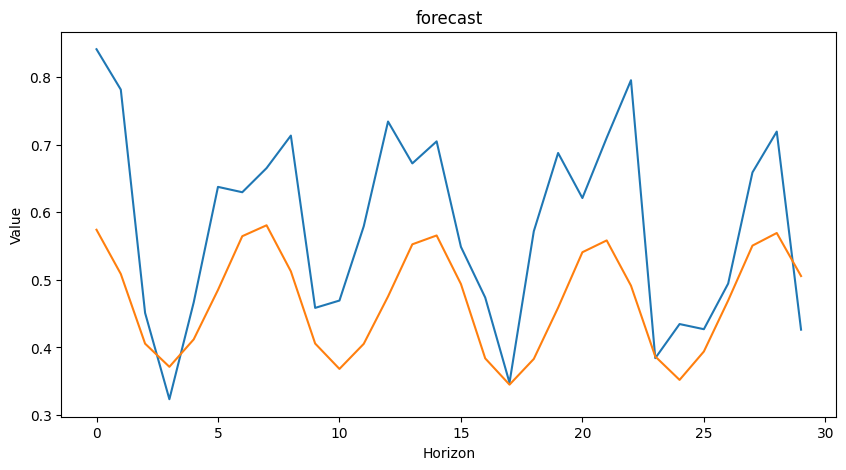

In [12]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = GRUForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.2104, Val Loss: 0.0906
Epoch 2/10, Train Loss: 0.0313, Val Loss: 0.0291
Epoch 3/10, Train Loss: 0.0205, Val Loss: 0.0248
Epoch 4/10, Train Loss: 0.0169, Val Loss: 0.0128
Epoch 5/10, Train Loss: 0.0163, Val Loss: 0.0169
Epoch 6/10, Train Loss: 0.0158, Val Loss: 0.0187
Epoch 7/10, Train Loss: 0.0157, Val Loss: 0.0177
Epoch 8/10, Train Loss: 0.0157, Val Loss: 0.0171
Epoch 9/10, Train Loss: 0.0156, Val Loss: 0.0172
Epoch 10/10, Train Loss: 0.0156, Val Loss: 0.0173


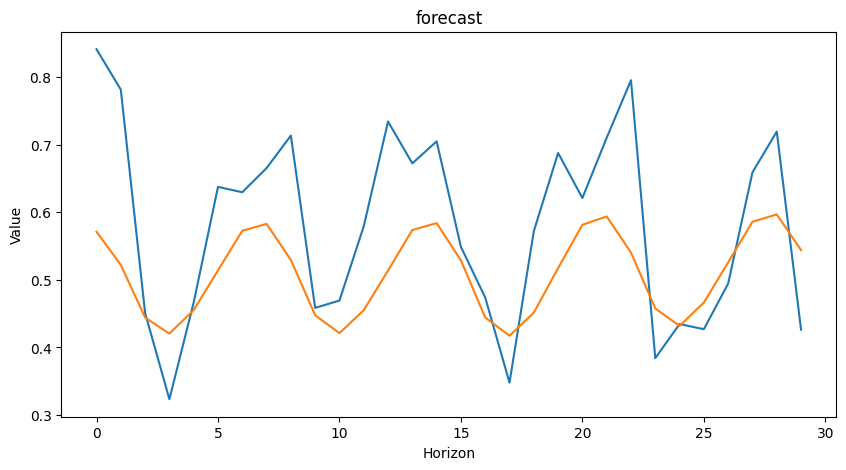

In [13]:


df = load_data("incoming.csv", freq=freq) # "outcoming.csv"  freq = "D" - по дням
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.1109, Val Loss: 0.0197
Epoch 2/10, Train Loss: 0.0224, Val Loss: 0.0243
Epoch 3/10, Train Loss: 0.0188, Val Loss: 0.0144
Epoch 4/10, Train Loss: 0.0167, Val Loss: 0.0155
Epoch 5/10, Train Loss: 0.0159, Val Loss: 0.0207
Epoch 6/10, Train Loss: 0.0158, Val Loss: 0.0212
Epoch 7/10, Train Loss: 0.0157, Val Loss: 0.0203
Epoch 8/10, Train Loss: 0.0157, Val Loss: 0.0199
Epoch 9/10, Train Loss: 0.0157, Val Loss: 0.0199
Epoch 10/10, Train Loss: 0.0156, Val Loss: 0.0199


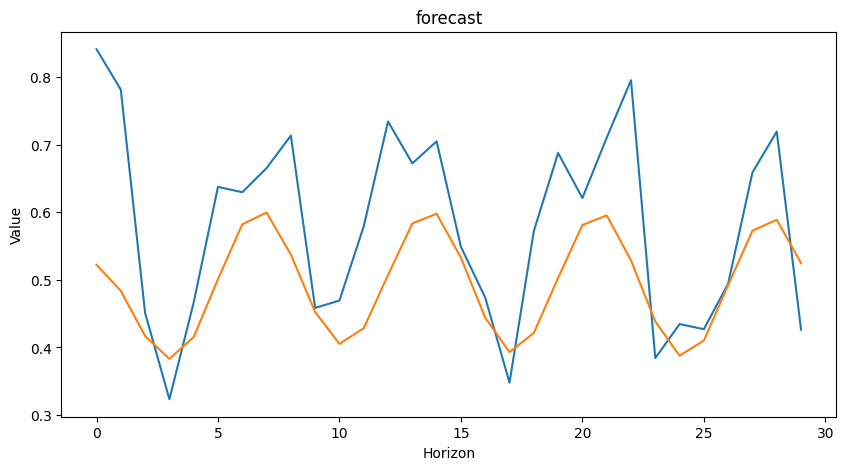

In [14]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0886, Val Loss: 0.0235
Epoch 2/10, Train Loss: 0.0204, Val Loss: 0.0205
Epoch 3/10, Train Loss: 0.0179, Val Loss: 0.0147
Epoch 4/10, Train Loss: 0.0166, Val Loss: 0.0154
Epoch 5/10, Train Loss: 0.0160, Val Loss: 0.0188
Epoch 6/10, Train Loss: 0.0159, Val Loss: 0.0193
Epoch 7/10, Train Loss: 0.0158, Val Loss: 0.0189
Epoch 8/10, Train Loss: 0.0158, Val Loss: 0.0187
Epoch 9/10, Train Loss: 0.0158, Val Loss: 0.0188
Epoch 10/10, Train Loss: 0.0157, Val Loss: 0.0188


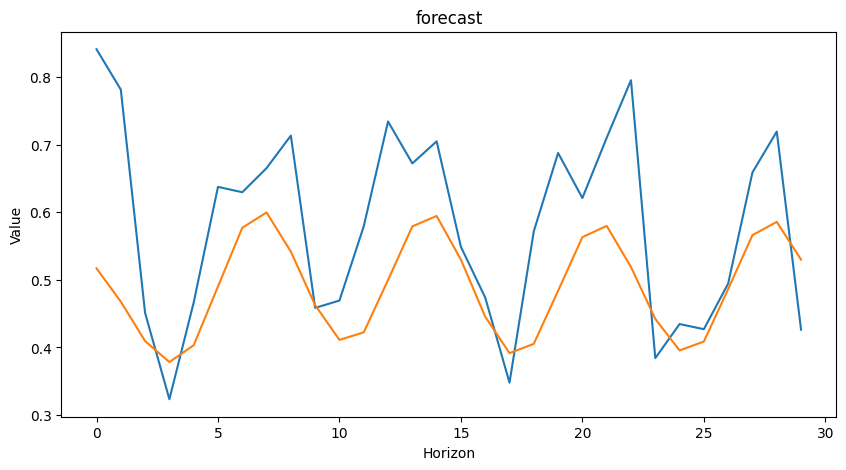

In [15]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.1184, Val Loss: 0.0278
Epoch 2/10, Train Loss: 0.0267, Val Loss: 0.0134
Epoch 3/10, Train Loss: 0.0190, Val Loss: 0.0248
Epoch 4/10, Train Loss: 0.0170, Val Loss: 0.0160
Epoch 5/10, Train Loss: 0.0161, Val Loss: 0.0154
Epoch 6/10, Train Loss: 0.0158, Val Loss: 0.0169
Epoch 7/10, Train Loss: 0.0158, Val Loss: 0.0163
Epoch 8/10, Train Loss: 0.0158, Val Loss: 0.0158
Epoch 9/10, Train Loss: 0.0157, Val Loss: 0.0160
Epoch 10/10, Train Loss: 0.0157, Val Loss: 0.0160


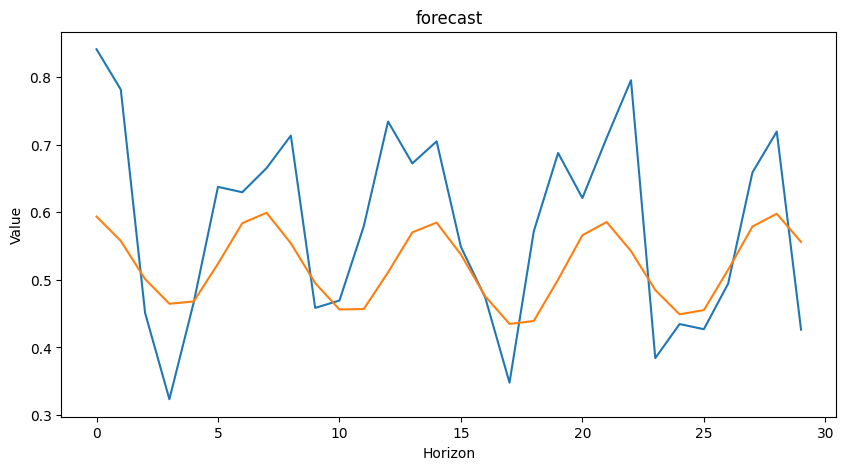

In [16]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.1028, Val Loss: 0.0696
Epoch 2/10, Train Loss: 0.0305, Val Loss: 0.0144
Epoch 3/10, Train Loss: 0.0201, Val Loss: 0.0349
Epoch 4/10, Train Loss: 0.0175, Val Loss: 0.0161
Epoch 5/10, Train Loss: 0.0165, Val Loss: 0.0190
Epoch 6/10, Train Loss: 0.0161, Val Loss: 0.0190
Epoch 7/10, Train Loss: 0.0160, Val Loss: 0.0174
Epoch 8/10, Train Loss: 0.0160, Val Loss: 0.0174
Epoch 9/10, Train Loss: 0.0160, Val Loss: 0.0178
Epoch 10/10, Train Loss: 0.0160, Val Loss: 0.0178


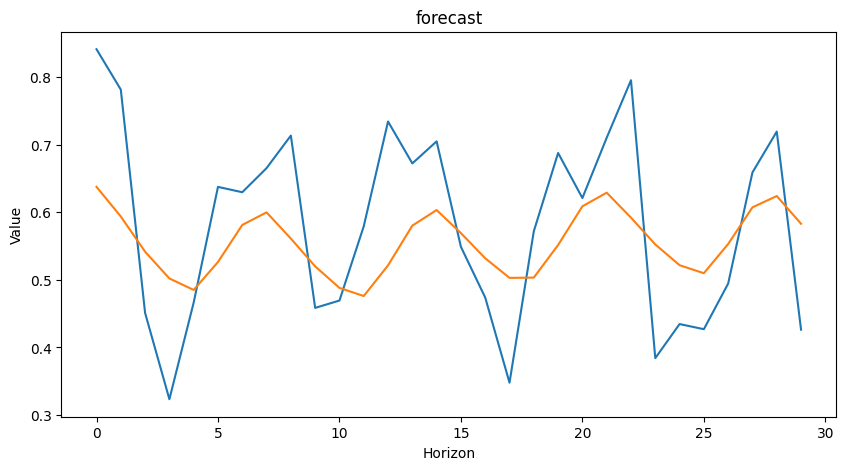

In [17]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)



model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



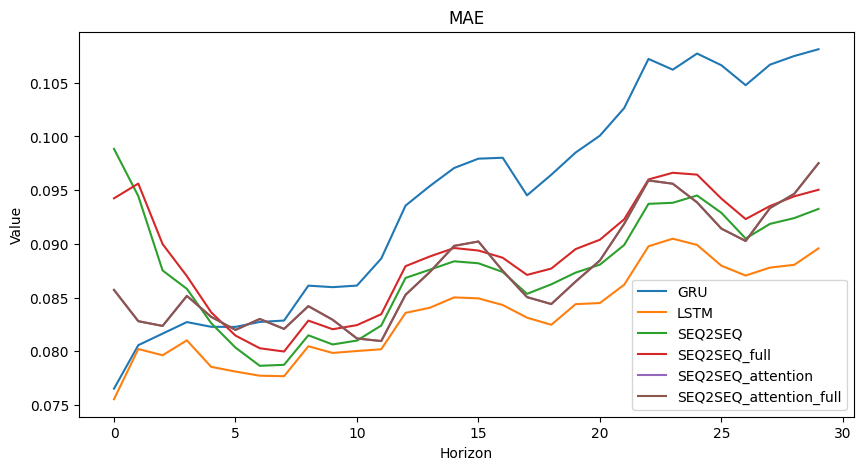

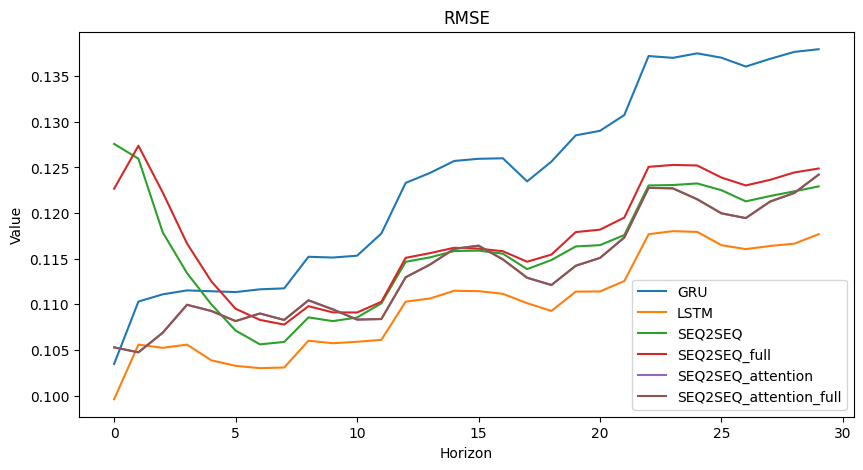

In [18]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)

### Outgoing day

In [19]:
mae_results = {}
rmse_results = {}

In [20]:
# Гиперпараметры
SEQ_LEN = 14  # длина входной последовательность
TRAIN_HORIZON = 7  # длина прогноза для обучения
EVAL_HORIZON = 30  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 1
EPOCHS = 10
LR = 1e-3
data = "outcoming.csv"
target ="outgoing_volume" 
save_dir = "torch_res/out_day"
freq = "D"

Epoch 1/10, Train Loss: 0.2860, Val Loss: 0.0128
Epoch 2/10, Train Loss: 0.0343, Val Loss: 0.0408
Epoch 3/10, Train Loss: 0.0255, Val Loss: 0.0194
Epoch 4/10, Train Loss: 0.0198, Val Loss: 0.0102
Epoch 5/10, Train Loss: 0.0184, Val Loss: 0.0181
Epoch 6/10, Train Loss: 0.0182, Val Loss: 0.0176
Epoch 7/10, Train Loss: 0.0184, Val Loss: 0.0153
Epoch 8/10, Train Loss: 0.0184, Val Loss: 0.0152
Epoch 9/10, Train Loss: 0.0180, Val Loss: 0.0155
Epoch 10/10, Train Loss: 0.0183, Val Loss: 0.0154


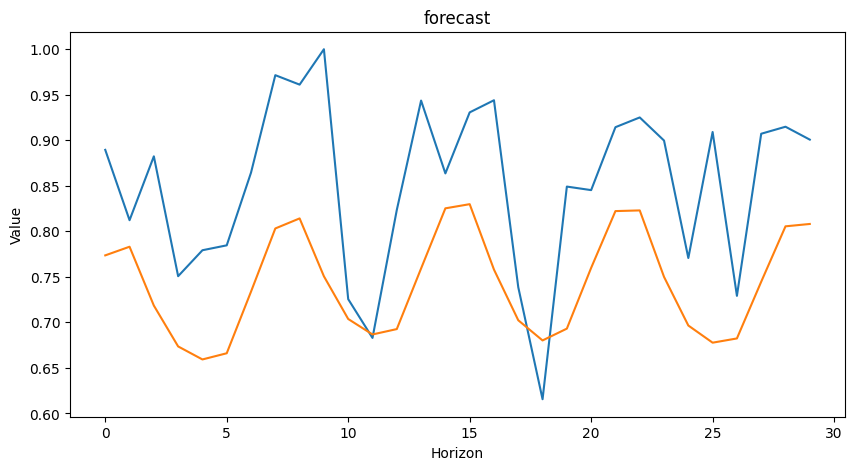

In [21]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = GRUForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.4669, Val Loss: 0.2567
Epoch 2/10, Train Loss: 0.0750, Val Loss: 0.0230
Epoch 3/10, Train Loss: 0.0281, Val Loss: 0.0153
Epoch 4/10, Train Loss: 0.0219, Val Loss: 0.0084
Epoch 5/10, Train Loss: 0.0195, Val Loss: 0.0180
Epoch 6/10, Train Loss: 0.0191, Val Loss: 0.0113
Epoch 7/10, Train Loss: 0.0190, Val Loss: 0.0111
Epoch 8/10, Train Loss: 0.0189, Val Loss: 0.0131
Epoch 9/10, Train Loss: 0.0186, Val Loss: 0.0132
Epoch 10/10, Train Loss: 0.0188, Val Loss: 0.0126


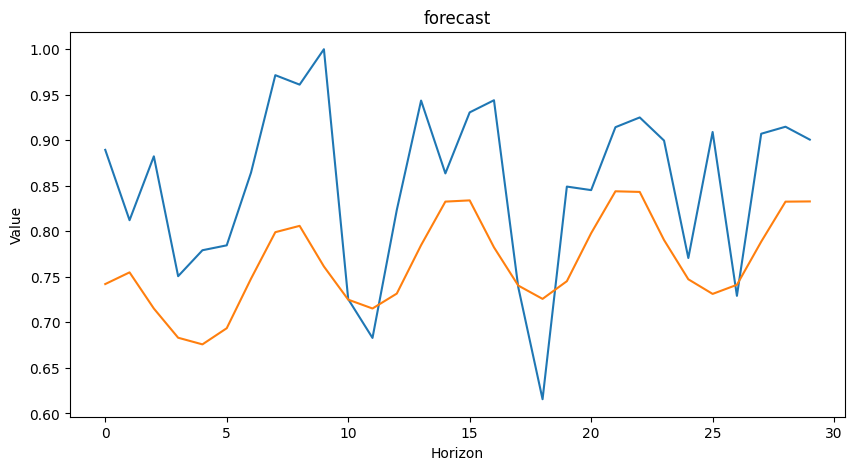

In [22]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.2625, Val Loss: 0.0539
Epoch 2/10, Train Loss: 0.0350, Val Loss: 0.0337
Epoch 3/10, Train Loss: 0.0236, Val Loss: 0.0091
Epoch 4/10, Train Loss: 0.0199, Val Loss: 0.0183
Epoch 5/10, Train Loss: 0.0182, Val Loss: 0.0254
Epoch 6/10, Train Loss: 0.0178, Val Loss: 0.0210
Epoch 7/10, Train Loss: 0.0179, Val Loss: 0.0209
Epoch 8/10, Train Loss: 0.0179, Val Loss: 0.0225
Epoch 9/10, Train Loss: 0.0176, Val Loss: 0.0224
Epoch 10/10, Train Loss: 0.0178, Val Loss: 0.0216


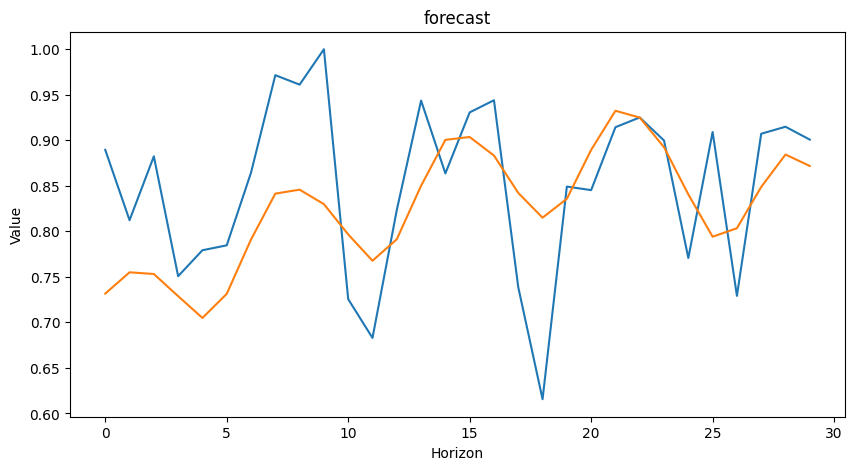

In [23]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.2162, Val Loss: 0.0550
Epoch 2/10, Train Loss: 0.0303, Val Loss: 0.0288
Epoch 3/10, Train Loss: 0.0221, Val Loss: 0.0082
Epoch 4/10, Train Loss: 0.0194, Val Loss: 0.0123
Epoch 5/10, Train Loss: 0.0176, Val Loss: 0.0194
Epoch 6/10, Train Loss: 0.0174, Val Loss: 0.0172
Epoch 7/10, Train Loss: 0.0176, Val Loss: 0.0170
Epoch 8/10, Train Loss: 0.0176, Val Loss: 0.0183
Epoch 9/10, Train Loss: 0.0173, Val Loss: 0.0186
Epoch 10/10, Train Loss: 0.0175, Val Loss: 0.0182


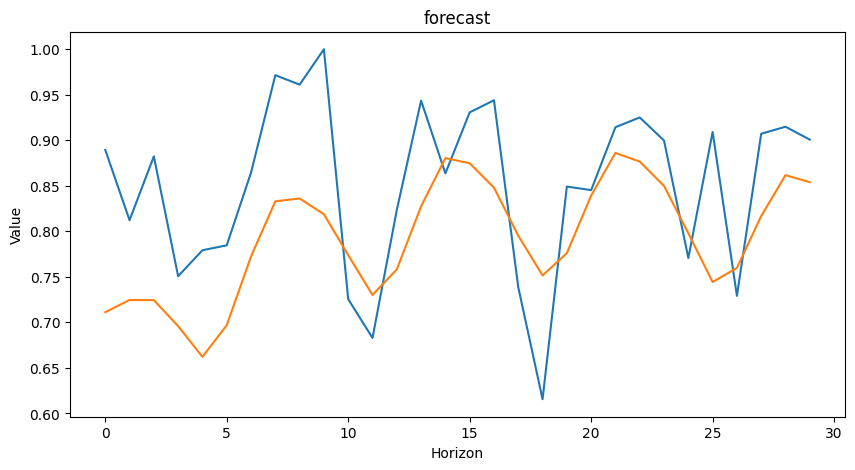

In [24]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.2497, Val Loss: 0.0108
Epoch 2/10, Train Loss: 0.0305, Val Loss: 0.0083
Epoch 3/10, Train Loss: 0.0241, Val Loss: 0.0316
Epoch 4/10, Train Loss: 0.0211, Val Loss: 0.0114
Epoch 5/10, Train Loss: 0.0190, Val Loss: 0.0172
Epoch 6/10, Train Loss: 0.0187, Val Loss: 0.0125
Epoch 7/10, Train Loss: 0.0187, Val Loss: 0.0134
Epoch 8/10, Train Loss: 0.0186, Val Loss: 0.0148
Epoch 9/10, Train Loss: 0.0184, Val Loss: 0.0142
Epoch 10/10, Train Loss: 0.0185, Val Loss: 0.0135


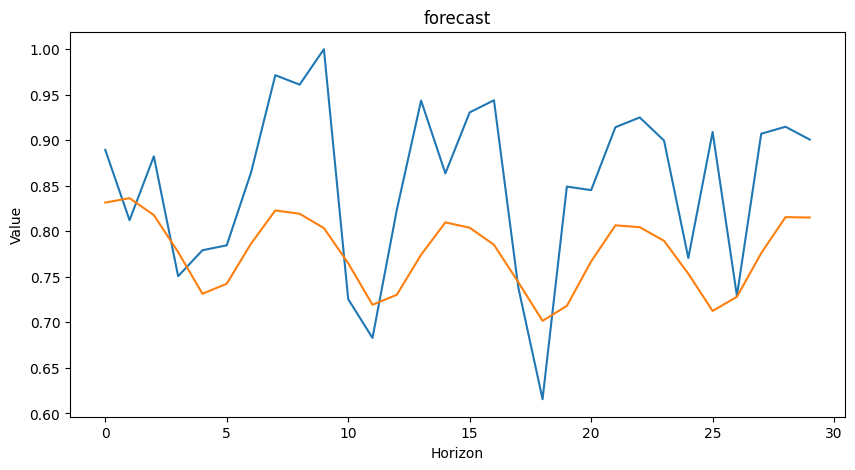

In [25]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.2197, Val Loss: 0.0345
Epoch 2/10, Train Loss: 0.0336, Val Loss: 0.0106
Epoch 3/10, Train Loss: 0.0233, Val Loss: 0.0336
Epoch 4/10, Train Loss: 0.0209, Val Loss: 0.0170
Epoch 5/10, Train Loss: 0.0196, Val Loss: 0.0198
Epoch 6/10, Train Loss: 0.0190, Val Loss: 0.0144
Epoch 7/10, Train Loss: 0.0189, Val Loss: 0.0169
Epoch 8/10, Train Loss: 0.0189, Val Loss: 0.0177
Epoch 9/10, Train Loss: 0.0187, Val Loss: 0.0167
Epoch 10/10, Train Loss: 0.0187, Val Loss: 0.0160


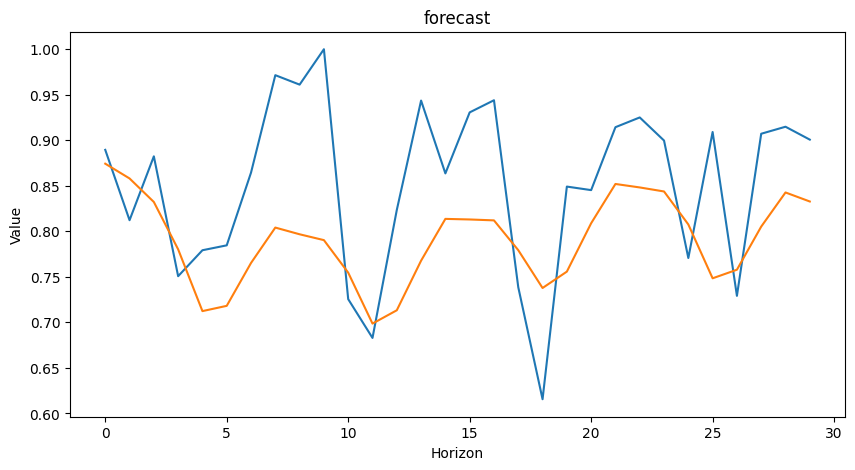

In [26]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)


model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



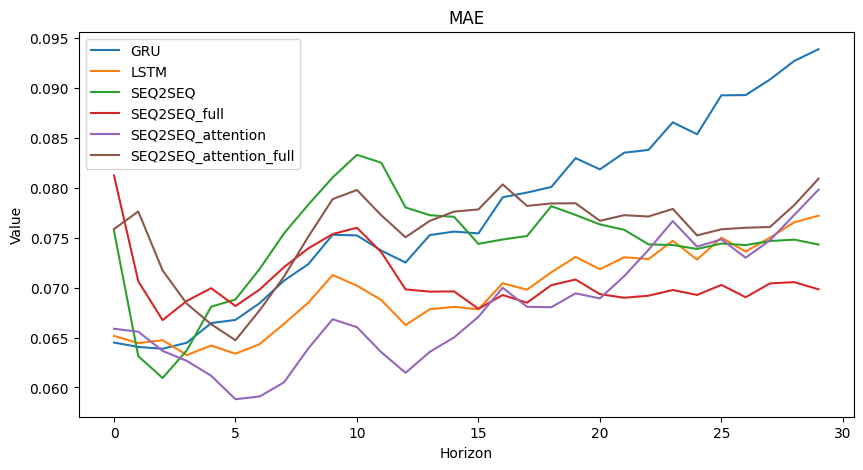

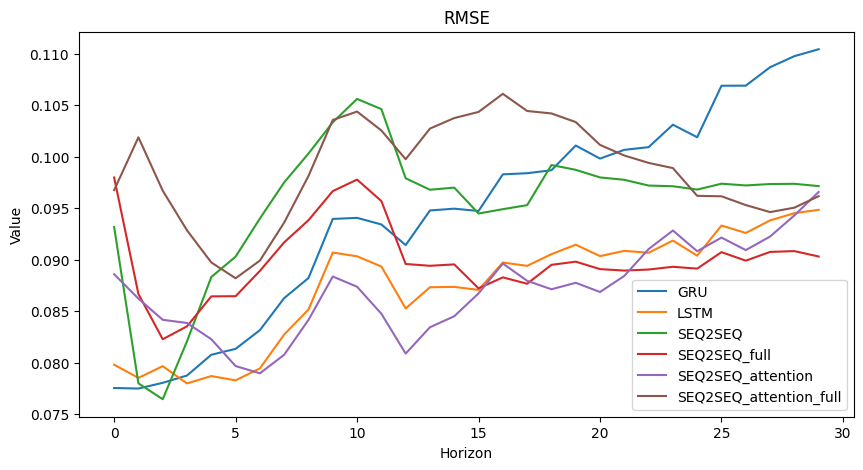

In [27]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)

### Incoming hour

In [28]:
mae_results = {}
rmse_results = {}

In [29]:
# Гиперпараметры
SEQ_LEN = 24*2  # длина входной последовательность
TRAIN_HORIZON = 24*2  # длина прогноза для обучения
EVAL_HORIZON = 24*7  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 2
EPOCHS = 10
LR = 1e-3
data = "incoming.csv"
target ="incoming_volume" 
save_dir = "torch_res/inc_hour"

freq = "h"

Epoch 1/10, Train Loss: 0.0223, Val Loss: 0.0236
Epoch 2/10, Train Loss: 0.0193, Val Loss: 0.0238
Epoch 3/10, Train Loss: 0.0188, Val Loss: 0.0244
Epoch 4/10, Train Loss: 0.0186, Val Loss: 0.0231
Epoch 5/10, Train Loss: 0.0184, Val Loss: 0.0239
Epoch 6/10, Train Loss: 0.0182, Val Loss: 0.0241
Epoch 7/10, Train Loss: 0.0180, Val Loss: 0.0240
Epoch 8/10, Train Loss: 0.0179, Val Loss: 0.0242
Epoch 9/10, Train Loss: 0.0178, Val Loss: 0.0237
Epoch 10/10, Train Loss: 0.0177, Val Loss: 0.0239


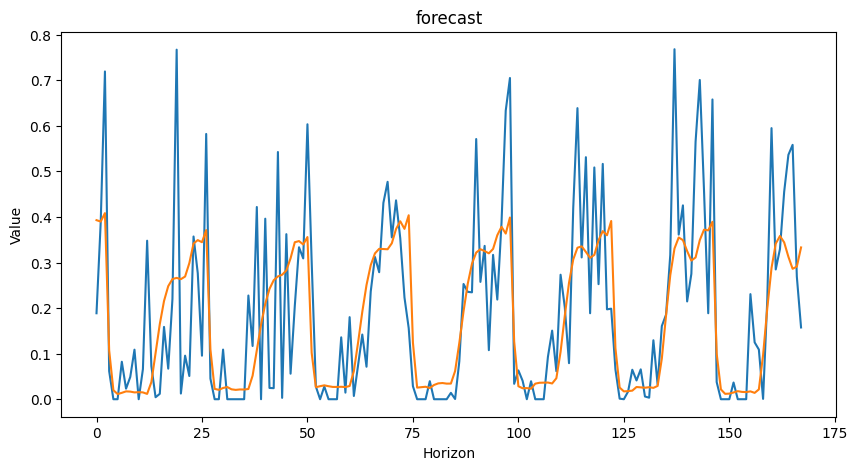

In [30]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = GRUForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.0228, Val Loss: 0.0236
Epoch 2/10, Train Loss: 0.0190, Val Loss: 0.0234
Epoch 3/10, Train Loss: 0.0185, Val Loss: 0.0244
Epoch 4/10, Train Loss: 0.0181, Val Loss: 0.0235
Epoch 5/10, Train Loss: 0.0176, Val Loss: 0.0239
Epoch 6/10, Train Loss: 0.0170, Val Loss: 0.0248
Epoch 7/10, Train Loss: 0.0164, Val Loss: 0.0249
Epoch 8/10, Train Loss: 0.0158, Val Loss: 0.0252
Epoch 9/10, Train Loss: 0.0153, Val Loss: 0.0254
Epoch 10/10, Train Loss: 0.0149, Val Loss: 0.0257


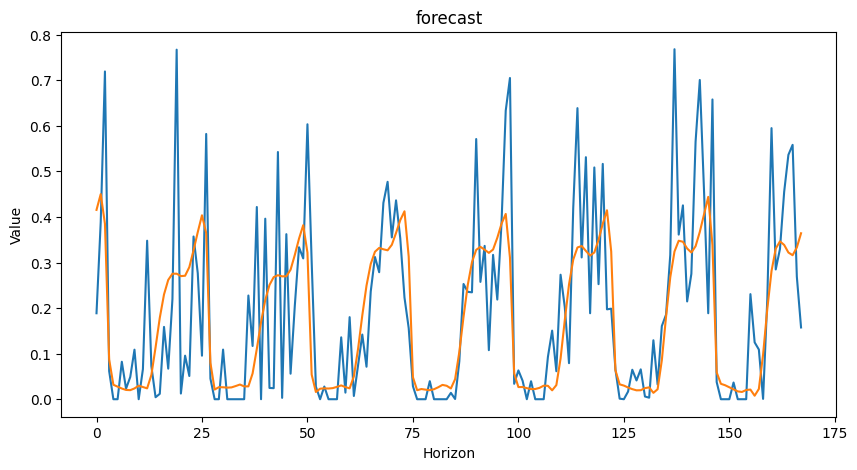

In [31]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.0226, Val Loss: 0.0254
Epoch 2/10, Train Loss: 0.0203, Val Loss: 0.0234
Epoch 3/10, Train Loss: 0.0191, Val Loss: 0.0240
Epoch 4/10, Train Loss: 0.0189, Val Loss: 0.0229
Epoch 5/10, Train Loss: 0.0187, Val Loss: 0.0234
Epoch 6/10, Train Loss: 0.0186, Val Loss: 0.0233
Epoch 7/10, Train Loss: 0.0185, Val Loss: 0.0233
Epoch 8/10, Train Loss: 0.0184, Val Loss: 0.0232
Epoch 9/10, Train Loss: 0.0184, Val Loss: 0.0232
Epoch 10/10, Train Loss: 0.0184, Val Loss: 0.0233


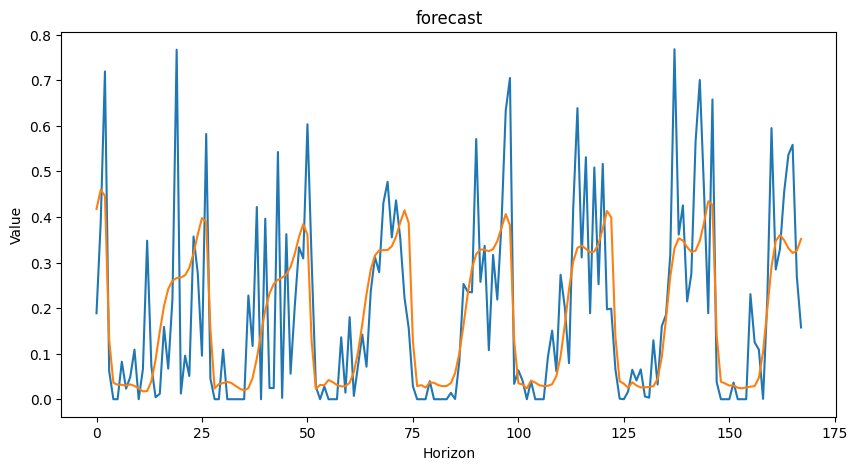

In [32]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням


train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0231, Val Loss: 0.0257
Epoch 2/10, Train Loss: 0.0211, Val Loss: 0.0235
Epoch 3/10, Train Loss: 0.0193, Val Loss: 0.0235
Epoch 4/10, Train Loss: 0.0189, Val Loss: 0.0230
Epoch 5/10, Train Loss: 0.0187, Val Loss: 0.0230
Epoch 6/10, Train Loss: 0.0185, Val Loss: 0.0231
Epoch 7/10, Train Loss: 0.0185, Val Loss: 0.0232
Epoch 8/10, Train Loss: 0.0183, Val Loss: 0.0230
Epoch 9/10, Train Loss: 0.0183, Val Loss: 0.0232
Epoch 10/10, Train Loss: 0.0183, Val Loss: 0.0231


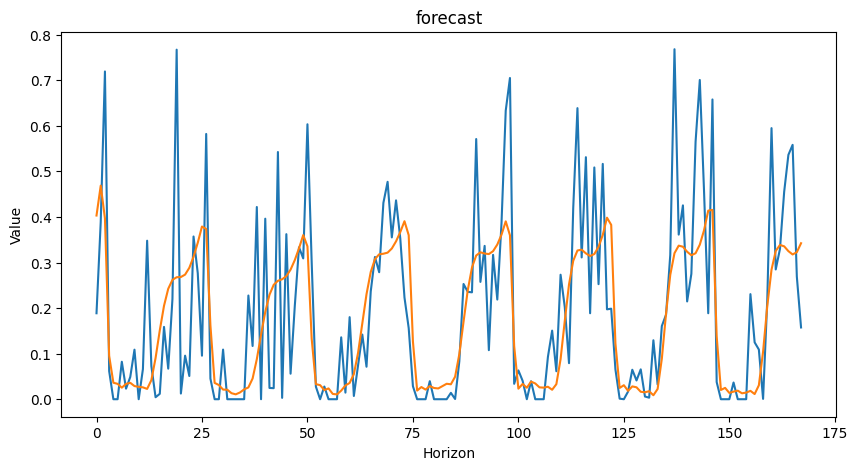

In [33]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0231, Val Loss: 0.0250
Epoch 2/10, Train Loss: 0.0204, Val Loss: 0.0239
Epoch 3/10, Train Loss: 0.0189, Val Loss: 0.0241
Epoch 4/10, Train Loss: 0.0186, Val Loss: 0.0232
Epoch 5/10, Train Loss: 0.0183, Val Loss: 0.0236
Epoch 6/10, Train Loss: 0.0181, Val Loss: 0.0237
Epoch 7/10, Train Loss: 0.0179, Val Loss: 0.0237
Epoch 8/10, Train Loss: 0.0178, Val Loss: 0.0236
Epoch 9/10, Train Loss: 0.0178, Val Loss: 0.0237
Epoch 10/10, Train Loss: 0.0176, Val Loss: 0.0237


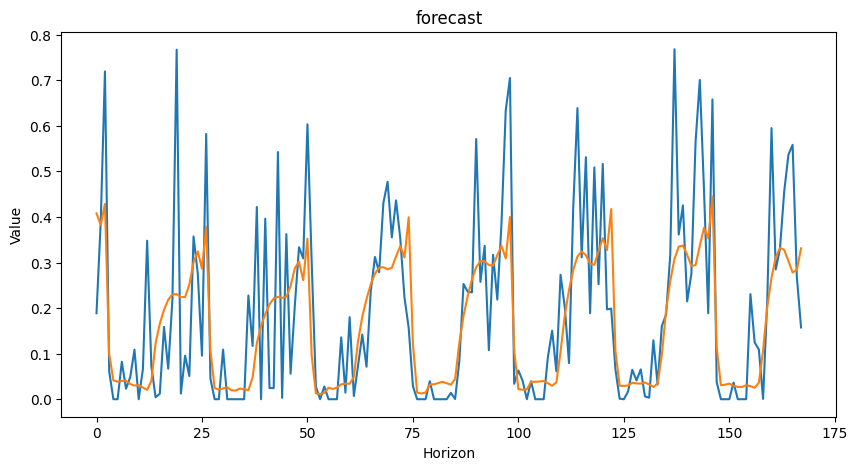

In [34]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням


train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0234, Val Loss: 0.0251
Epoch 2/10, Train Loss: 0.0206, Val Loss: 0.0242
Epoch 3/10, Train Loss: 0.0190, Val Loss: 0.0237
Epoch 4/10, Train Loss: 0.0188, Val Loss: 0.0229
Epoch 5/10, Train Loss: 0.0186, Val Loss: 0.0231
Epoch 6/10, Train Loss: 0.0184, Val Loss: 0.0233
Epoch 7/10, Train Loss: 0.0182, Val Loss: 0.0236
Epoch 8/10, Train Loss: 0.0180, Val Loss: 0.0233
Epoch 9/10, Train Loss: 0.0180, Val Loss: 0.0234
Epoch 10/10, Train Loss: 0.0178, Val Loss: 0.0234


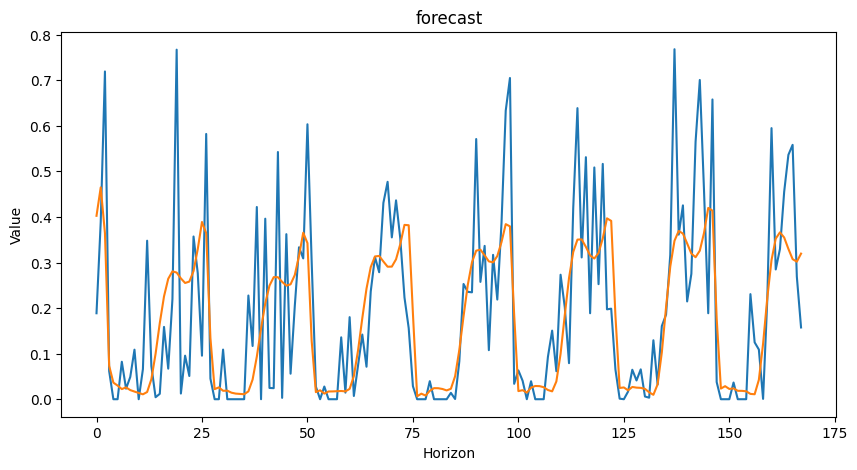

In [35]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



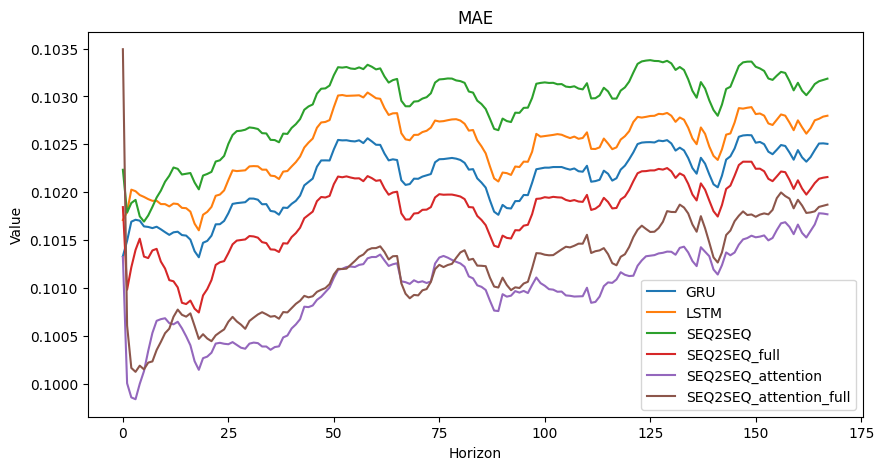

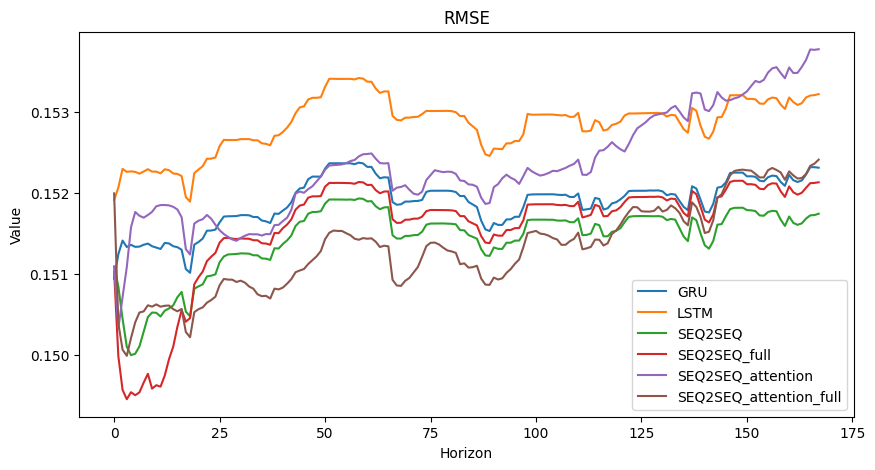

In [36]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)

### Outgoing hour

In [37]:
mae_results = {}
rmse_results = {}

In [38]:
# Гиперпараметры
SEQ_LEN = 24*2  # длина входной последовательность
TRAIN_HORIZON = 24*2  # длина прогноза для обучения
EVAL_HORIZON = 24*7  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 2
EPOCHS = 10
LR = 1e-3
data = "outcoming.csv"
target ="outgoing_volume" 
save_dir = "torch_res/out_hour"

freq = "h"

Epoch 1/10, Train Loss: 0.0284, Val Loss: 0.0299
Epoch 2/10, Train Loss: 0.0268, Val Loss: 0.0310
Epoch 3/10, Train Loss: 0.0254, Val Loss: 0.0301
Epoch 4/10, Train Loss: 0.0239, Val Loss: 0.0330
Epoch 5/10, Train Loss: 0.0226, Val Loss: 0.0312
Epoch 6/10, Train Loss: 0.0214, Val Loss: 0.0327
Epoch 7/10, Train Loss: 0.0203, Val Loss: 0.0338
Epoch 8/10, Train Loss: 0.0194, Val Loss: 0.0347
Epoch 9/10, Train Loss: 0.0188, Val Loss: 0.0359
Epoch 10/10, Train Loss: 0.0183, Val Loss: 0.0360


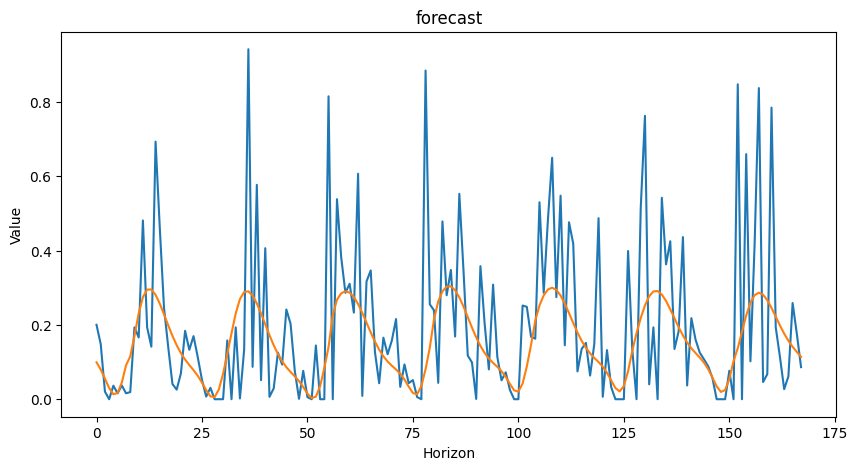

In [39]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = GRUForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.0291, Val Loss: 0.0296
Epoch 2/10, Train Loss: 0.0265, Val Loss: 0.0318
Epoch 3/10, Train Loss: 0.0251, Val Loss: 0.0338
Epoch 4/10, Train Loss: 0.0230, Val Loss: 0.0363
Epoch 5/10, Train Loss: 0.0203, Val Loss: 0.0374
Epoch 6/10, Train Loss: 0.0173, Val Loss: 0.0388
Epoch 7/10, Train Loss: 0.0148, Val Loss: 0.0398
Epoch 8/10, Train Loss: 0.0129, Val Loss: 0.0415
Epoch 9/10, Train Loss: 0.0118, Val Loss: 0.0420
Epoch 10/10, Train Loss: 0.0110, Val Loss: 0.0432


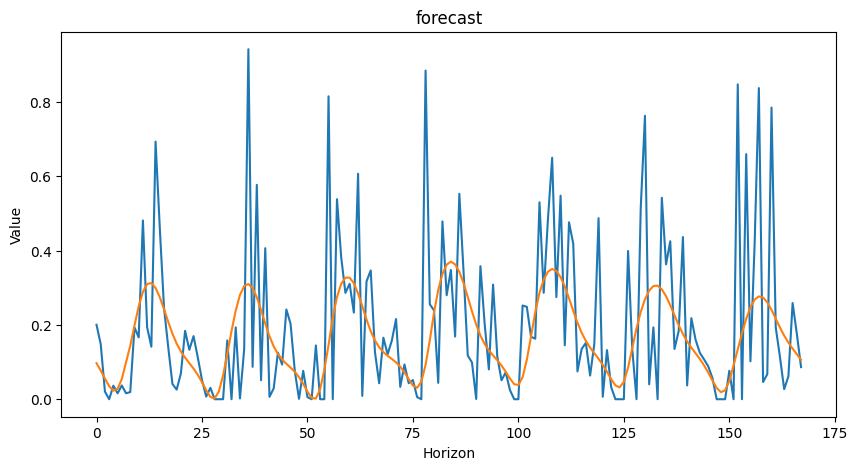

In [40]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.0283, Val Loss: 0.0298
Epoch 2/10, Train Loss: 0.0271, Val Loss: 0.0303
Epoch 3/10, Train Loss: 0.0263, Val Loss: 0.0319
Epoch 4/10, Train Loss: 0.0255, Val Loss: 0.0316
Epoch 5/10, Train Loss: 0.0248, Val Loss: 0.0305
Epoch 6/10, Train Loss: 0.0242, Val Loss: 0.0309
Epoch 7/10, Train Loss: 0.0238, Val Loss: 0.0313
Epoch 8/10, Train Loss: 0.0234, Val Loss: 0.0318
Epoch 9/10, Train Loss: 0.0232, Val Loss: 0.0322
Epoch 10/10, Train Loss: 0.0230, Val Loss: 0.0323


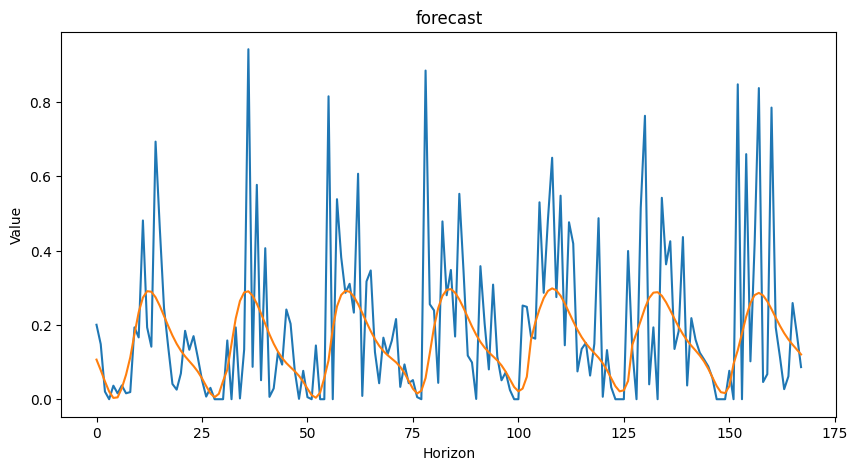

In [41]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням


train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0286, Val Loss: 0.0313
Epoch 2/10, Train Loss: 0.0272, Val Loss: 0.0303
Epoch 3/10, Train Loss: 0.0264, Val Loss: 0.0313
Epoch 4/10, Train Loss: 0.0256, Val Loss: 0.0302
Epoch 5/10, Train Loss: 0.0250, Val Loss: 0.0311
Epoch 6/10, Train Loss: 0.0246, Val Loss: 0.0311
Epoch 7/10, Train Loss: 0.0244, Val Loss: 0.0310
Epoch 8/10, Train Loss: 0.0242, Val Loss: 0.0312
Epoch 9/10, Train Loss: 0.0241, Val Loss: 0.0314
Epoch 10/10, Train Loss: 0.0240, Val Loss: 0.0311


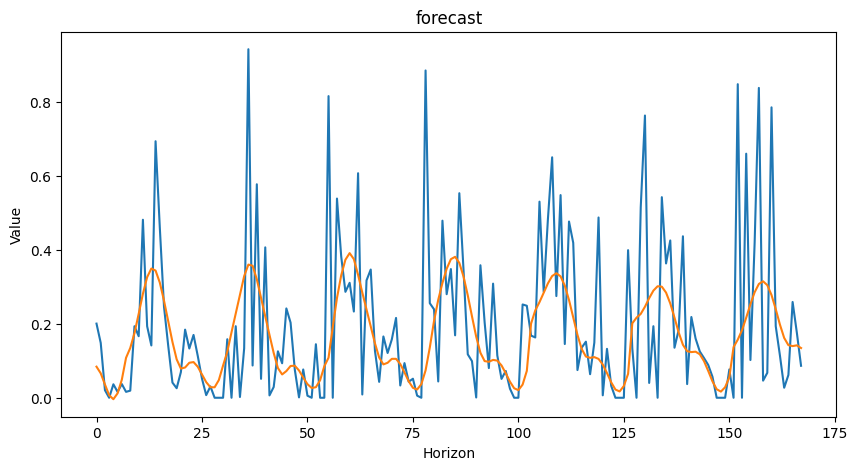

In [42]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0288, Val Loss: 0.0291
Epoch 2/10, Train Loss: 0.0268, Val Loss: 0.0300
Epoch 3/10, Train Loss: 0.0256, Val Loss: 0.0307
Epoch 4/10, Train Loss: 0.0244, Val Loss: 0.0311
Epoch 5/10, Train Loss: 0.0235, Val Loss: 0.0312
Epoch 6/10, Train Loss: 0.0228, Val Loss: 0.0327
Epoch 7/10, Train Loss: 0.0222, Val Loss: 0.0328
Epoch 8/10, Train Loss: 0.0217, Val Loss: 0.0331
Epoch 9/10, Train Loss: 0.0214, Val Loss: 0.0340
Epoch 10/10, Train Loss: 0.0211, Val Loss: 0.0339


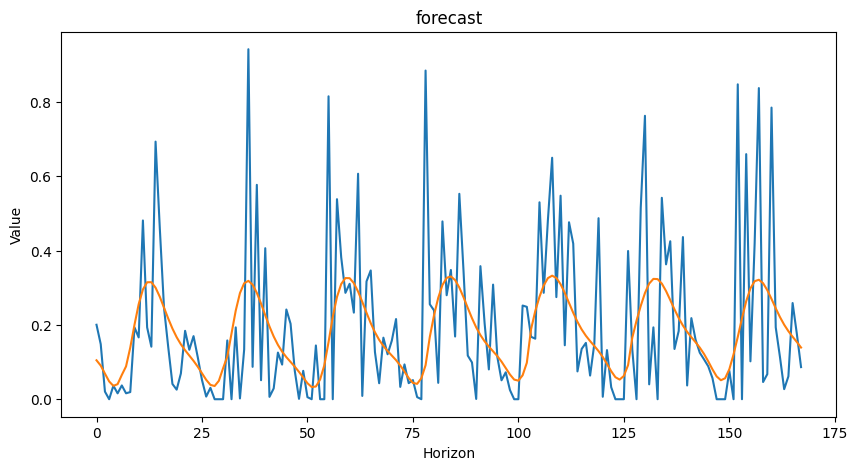

In [43]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням


train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0292, Val Loss: 0.0324
Epoch 2/10, Train Loss: 0.0270, Val Loss: 0.0291
Epoch 3/10, Train Loss: 0.0259, Val Loss: 0.0304
Epoch 4/10, Train Loss: 0.0247, Val Loss: 0.0308
Epoch 5/10, Train Loss: 0.0238, Val Loss: 0.0309
Epoch 6/10, Train Loss: 0.0231, Val Loss: 0.0331
Epoch 7/10, Train Loss: 0.0225, Val Loss: 0.0328
Epoch 8/10, Train Loss: 0.0219, Val Loss: 0.0335
Epoch 9/10, Train Loss: 0.0215, Val Loss: 0.0335
Epoch 10/10, Train Loss: 0.0213, Val Loss: 0.0343


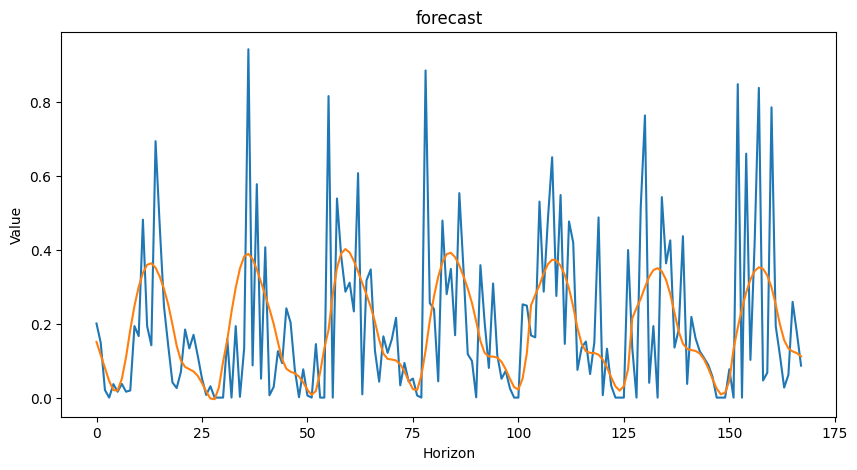

In [44]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



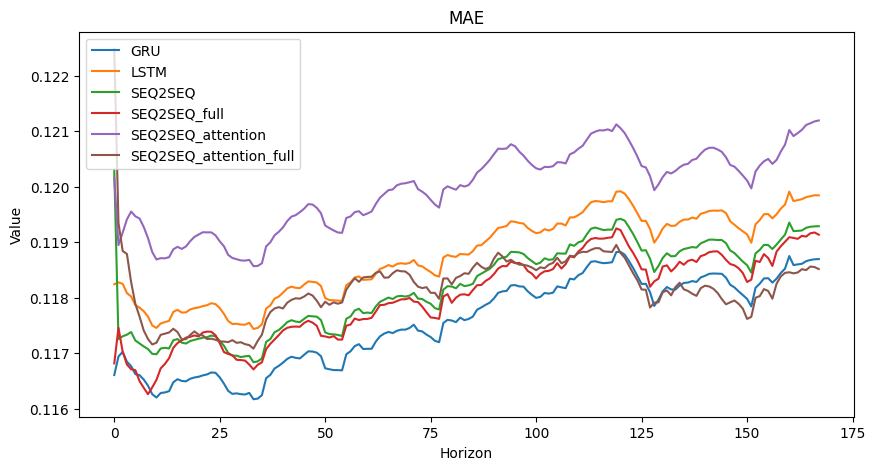

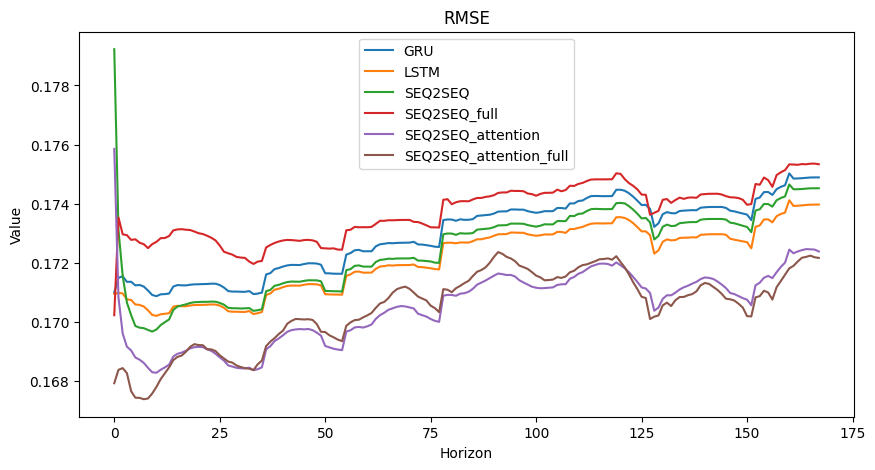

In [45]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)